In [1]:
%cd ..

/Users/sophiayeremeeva/Desktop/research/nyu/xeda-dagster/xeda


In [2]:
%cd data/annotated_pipelines

/Users/sophiayeremeeva/Desktop/research/nyu/xeda-dagster/xeda/data/annotated_pipelines


In [3]:
import chromadb
import copy
import json
import typing as t
import uuid
import pathlib
import os
from collections import Counter
import heapq
from collections import defaultdict
import statistics
import boto3
import random
import openai
import itertools
import typing as t

from chromadb.utils import embedding_functions
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from constants import (
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_S3_ENDPOINT_URL,
    AWS_S3_REGION_NAME,
    AWS_S3_BUCKET_NAME,
    AWS_S3_USE_SSL,
    OPENAI_API_KEY,
    VECTOR_STORE_COLLECTION,
    VECTOR_STORE_HOST,
    VECTOR_STORE_PORT
)



In [4]:
from pipeline.solid.pipeline_sampler import next_pipeline_iter

ValueError: Could not connect to a Chroma server. Are you sure it is running?

In [4]:
from utils.s3 import pull_keras_model
from typings.pipeline import Pipeline

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema.document import Document

In [6]:
pipelines = os.listdir()

In [7]:
def add_pipeline_id():
    for i, pipeline_file in enumerate(pipelines):
      try:
        with open(pipeline_file, 'r') as file:
            try:
                pipeline = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {pipeline_file}: {e}")
                continue
    
        for j, node in enumerate(pipeline):
            if 'annotation' in node:
                node['annotation']['current_step'] = j + 1
                node['annotation']['id'] = i + 1
                node['annotation']['type'] = pipeline_file[56:-5]
    
        with open(pipeline_file, 'w') as file:
            json.dump(pipeline, file, indent=4)
      except Exception as e:
        print(f"Error in folder: {e}")

In [8]:
add_pipeline_id()

Error in folder: 'utf-8' codec can't decode byte 0xb0 in position 22: invalid start byte


In [9]:
def pipeline2splits(pipeline: Pipeline) -> t.List[Pipeline]:
    splits = []

    for node in pipeline:
        pipeline_encoding = []
        annotation = node["annotation"]
        node_encoding = []
        for k, v in annotation.items():
            if isinstance(v, dict):
                for key in v:
                    node_encoding.append(f"{k}_{key} = {v[key]}")
            else:
                node_encoding.append(f"{k} = {v}")
        pipeline_encoding.append(', '.join(node_encoding))
        splits.append(copy.deepcopy(pipeline_encoding))
    return splits

In [10]:
import itertools

def splits2encoding() -> t.List:
    pipeline_splits = []
    encodings = ['utf-8', 'latin-1', 'utf-16']
    for pipeline_i in pipelines:
        # Try different encodings until successful or all encodings are exhausted
        for encoding in encodings:
            try:
                with open(pipeline_i, 'r', encoding=encoding) as file:
                    pipeline = json.load(file)

                    if(len(pipeline) > 5):
                        # print(len(pipeline))
                        pipeline_splits.append(list(itertools.chain.from_iterable(pipeline2splits(pipeline))))
                    break  # Break out of the loop if successful
            except Exception as e:
                print('exception ', e)
                continue  # Try next encoding if decoding fails
    
    return [', '.join(pipeline_split) for pipeline_split in pipeline_splits]

In [11]:
pipeline_encodings = splits2encoding()

9
6
6
7
8
15
9
6
6
8
8
8
8
8
8
8
7
7
13
13
10
8
15
13
7
8
6
9
8
7
14
9
9
11
6
6
8
14
12
7
8
7
9
16
6
7
8
10
16
6
6
8
7
8
10
9
9
7
7
10
7
8
8
9
6
6
6
6
7
6
14
11
10
9
8
10
11
9
exception  'utf-8' codec can't decode byte 0xb0 in position 22: invalid start byte
exception  Expecting value: line 1 column 1 (char 0)
exception  'utf-16-le' codec can't decode bytes in position 16736-16737: illegal encoding
6
6
8
7
8
7
12
6
13
15
14
9
9
12
8
7
12
6
14
10
6
9
6
6
11
6
9
10
6
6
11
9
6
7
8
7
9
6
9
9
6
10
10
9
12
7
11
8
9
7
6
7
8
6
6
10
11
11
8
7
8
10
8
7
6
6
9
9
9
6
6
8
8
12
8
7
9
7
9
6
16
8
11
8
10
9
8
9
6
12
7
15
16
7
6
9
7
9
8
7
7
6
10
9
16
8
8
7
9
7
6
8
7
14
11
9
6
9
8
6
6
8
7
7
8
9
6
7
7
8
12
8
14
7
8
12
9
9
7
15
8
7
8
8
6
9
7
6
7
13
6
9
10
7
7
6
8
7
13
9
8
8
14
9
10
9
7
10
9
8
9
9
7
8
14
8
7
10
7
9
14
9
8
15
8
16
16
7
8
11
7
12
11
7
9
8
12
9
15
9
9
7
9
6
6
14
9
8
8
6
15
8
7
6
15
13
9
7
15
13
8
14
6
9
14
6
8
7
11
6
9
7
11
7
9
9
6
9
16
6
15
8
8
6
10
15
7
7
7
13
11
9
11
7
12
10
7
6
6
7
8
15
8
6

In [12]:
len(pipeline_encodings)

545

In [13]:
import openai
API_KEY=""
openai.api_key = API_KEY
openai_embeddings = OpenAIEmbeddings(api_key=API_KEY)

In [14]:
def generate_vector_store(pipeline_encodings) -> Chroma:
  vector_store = Chroma.from_texts(pipeline_encodings[300:], openai_embeddings)
  return vector_store

# NLE

In [15]:
def similarity_search(input : str, vector_store: Chroma, step: int):
    similar_pipelines = vector_store.similarity_search(input, k=15)
    all_dicts = []

    for pipeline in similar_pipelines:
        content = pipeline.page_content
        dictionary = str_to_dict(content, step)
        if dictionary != None:
          all_dicts.append(dictionary)

    return all_dicts

In [60]:
def str_to_dict(input_str, step):
    # print(input_str)
    try:
      node = re.search(f'current_step = {step}, (.*?), current_step = {step+1}', str(input_str), re.DOTALL)
      matched_substring = node.group(1)
      # print(matched_substring)
      new_string = re.sub(r'\[.*?\]', '[]', matched_substring)
      items = new_string.split(', ')
      result_dict = {}
      # print(f"long pipeline: {re.search('total_length = (.*?), ', str(input_str), re.DOTALL).group(0)}")

      for item in items:
          key, value = item.split(' = ')
          if 'Weights' in key.strip():
              continue
          elif '.' in value:
              value = float(value)
          elif value.isdigit():
              value = int(value)

          result_dict[key] = value
      return result_dict
    except:
        pass
     # print(f"short pipeline: {re.search('total_length = (.*?), ', str(input_str), re.DOTALL).group(0)}")

In [17]:
def number_of_sim_pipelines(all_dicts):
  return len(all_dicts)

In [18]:
def length(all_dicts):
  counts_length = Counter(d['total_length'] for d in all_dicts)
  percentages_length = {key: count / len(counts_length) * 100 for key, count in counts_length.items()}

  max_length = max(percentages_length, key=lambda k: percentages_length[k])
  return int(max_length)

In [19]:
def scattered_concentrated(all_dicts):
  type_counts = defaultdict(int)
  for one_dict in all_dicts:
    type_value = one_dict.get('type')
    if type_value in type_counts:
        type_counts[type_value] += 1
    else:
        type_counts[type_value] = 1

  if type_counts:
    try:
        most_common_type = max(type_counts, key=type_counts.get)
        return most_common_type
    except Exception as e:
        print(e)
  else:
    return None

In [20]:
def dist_operators(all_dicts):
  operators = ['remaining_operators_by_neighbors', 'remaining_operators_by_superset', 'remaining_operators_by_distribution', 'remaining_operators_by_facet']
  operator_values = defaultdict(float)

  for operator in operators:
      operator_values[operator] += sum(one_dict.get(operator, 0.0) for one_dict in all_dicts)

  total_count = sum(operator_values.values()) + 0.000001
  percentages_length = {key: value / total_count * 100 for key, value in operator_values.items()}

  top_keys = heapq.nlargest(4, percentages_length.items(), key=lambda x: x[1])
  return top_keys

In [21]:
def dimensions(all_dicts):
  dimensions = ['remaining_dimensions_u', 'remaining_dimensions_g', 'remaining_dimensions_r', 'remaining_dimensions_i', 'remaining_dimensions_z', 'remaining_dimensions_petroRad_r', 'remaining_dimensions_redshift']
  dimensions_values = defaultdict(float)

  for dimension in dimensions:
      dimensions_values[dimension] += sum(one_dict.get(dimension, 0.0) for one_dict in all_dicts)

  total_count = sum(dimensions_values.values()) + 0.000001
  percentages_length = {key: value / total_count * 100 for key, value in dimensions_values.items()}

  top_keys = heapq.nlargest(4, percentages_length.items(), key=lambda x: x[1])
  return top_keys

In [22]:
def familiarity(all_dicts):
  counts = [d['familiarity'] for d in all_dicts]

  return (statistics.median(counts))

In [63]:
def generate_guidance(all_dicts, step):
  total_length = length(all_dicts)
  operator = dist_operators(all_dicts)
  dimension = dimensions(all_dicts)
  fam = familiarity(all_dicts)
  k = number_of_sim_pipelines(all_dicts)
  steps = total_length - step
  type_sc = scattered_concentrated(all_dicts)

  print(f' On average \033[94m{steps}\033[0m step/s, you will reach a \033[94m{type_sc}\033[0m set with an expected final familiarity of \033[94m{fam}\033[0m. \n',
        f'You are more likely to get there by focusing on the \033[94m{operator[0][0][20:]}\033[0m and \033[94m{operator[1][0][20:]}\033[0m operators and on \033[94m{dimension[0][0][21:]}\033[0m and \033[94m{dimension[1][0][21:]}\033[0m dimensions \n',
        f'You will probably finish with total length of \033[94m{total_length}\033[0m. \n',
        f'You get this guidance because: in the \033[94m{k}\033[0m similar pipelines the following distribution of operator \033[94m{operator[0][0][20:]}\033[0m is \033[94m{round(operator[0][1], 2)}\033[0m, \033[94m{operator[1][0][20:]}\033[0m is \033[94m{round(operator[1][1], 2)}\033[0m, \033[94m{operator[2][0][20:]}\033[0m is \033[94m{round(operator[2][1], 2)}\033[0m, \033[94m{operator[3][0][20:]}\033[0m is \033[94m{round(operator[3][1], 2)}\033[0m; \n',
        f'the distribution of dimension \033[94m{dimension[0][0][21:]}\033[0m is \033[94m{round(dimension[0][1], 2)}\033[0m, \033[94m{dimension[1][0][21:]}\033[0m is \033[94m{round(dimension[1][1], 2)}\033[0m, \033[94m{dimension[2][0][21:]}\033[0m is \033[94m{round(dimension[2][1], 2)}\033[0m, \033[94m{dimension[3][0][21:]}\033[0m is \033[94m{round(dimension[3][1], 2)}\033[0m. ')

In [24]:
step_3_input = """current_step = 6,
                  current_operator = by_superset,
                  utility	=	0.8128546883734933,
                  uniformity =	0.595077585008306,
                  novelty =	0.8154882106352771,
                  diversity	=	0.5752419701946976,
                  galaxy_class_score	=	3.940769949500628"""

In [25]:
vector_store_embeddings = generate_vector_store(pipeline_encodings)

In [26]:
import re
similar_steps = similarity_search(input=step_3_input, vector_store=vector_store_embeddings, step=6)

short pipeline: total_length = 6, 
long pipeline: total_length = 7, 
long pipeline: total_length = 8, 
long pipeline: total_length = 10, 
long pipeline: total_length = 9, 
long pipeline: total_length = 8, 
long pipeline: total_length = 8, 
long pipeline: total_length = 7, 
long pipeline: total_length = 8, 
long pipeline: total_length = 7, 
long pipeline: total_length = 8, 
long pipeline: total_length = 8, 
long pipeline: total_length = 7, 
long pipeline: total_length = 7, 
short pipeline: total_length = 6, 


In [44]:
generate_guidance(similar_steps, 3)

[('remaining_operators_by_neighbors', 0.0), ('remaining_operators_by_superset', 0.0), ('remaining_operators_by_distribution', 0.0), ('remaining_operators_by_facet', 0.0)]
 On average 9 step/s, you will reach a concentrated set with an expected final familiarity of 0.0. 
 You are more likely to get there by focusing on the by_neighbors and by_superset operators and on u and g dimensions 
 You will probably finish with total length of 12. 
 You get this guidance because: in the 1 similar pipelines the following distribution of operator by_neighbors is 0.0, by_superset is 0.0, by_distribution is 0.0, by_facet is 0.0; 
 the distribution of dimension u is 0.0, g is 0.0, r is 0.0, i is 0.0. 


# Get a model (Danyil Code)

In [60]:
pretrained_embeddings = embedding_functions.OpenAIEmbeddingFunction(
    api_key=OPENAI_API_KEY,
    model_name="text-embedding-ada-002"
)

vector_store = chromadb.HttpClient(
    host=VECTOR_STORE_HOST, 
    port=VECTOR_STORE_PORT
)

ValueError: Could not connect to a Chroma server. Are you sure it is running?

In [61]:
vector_collection = vector_store.get_collection(VECTOR_STORE_COLLECTION)

NameError: name 'vector_store' is not defined

In [62]:
annotated_pipelines = []
for pipeline_file in pipelines:
    with open(pipeline_file, 'r') as file:
        annotated_pipelines.append(json.load(file))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 22: invalid start byte

In [114]:
def pipeline_to_embedding(pipeline: Pipeline):
    pipeline_splits = pipeline_to_splits(pipeline)
    pipeline_payload = (
        [str(uuid.uuid4()) for _ in range(len(pipeline_splits))],
        [json.dumps(copy.deepcopy(pipeline)) for _ in range(len(pipeline_splits))],
        [';'.join(pipeline_split) for pipeline_split in pipeline_splits]
    )
    return pipeline_payload

In [116]:
def pipeline_to_splits(pipeline: Pipeline) -> t.List[Pipeline]:
    splits = []
    pipeline_encoding = []
    for node in reversed(pipeline):
        node_encoding = node_to_encoding(node)
        pipeline_encoding.append(node_encoding)
        splits.append(copy.deepcopy(pipeline_encoding))
    return splits

In [118]:
def node_to_encoding(node):
    annotation = node["annotation"]
    node_encoding = []
    for k, v in annotation.items():
        if isinstance(v, dict):
            for key in v:
                node_encoding.append(f"{k}_{key} = {v[key]}")
        else:
            node_encoding.append(f"{k} = {v}")
    return ', '.join(node_encoding)


In [119]:
for annotated_pipeline in annotated_pipelines:
    (
        pipeline_ids,
        pipeline_documents,
        pipeline_sentences
    ) = pipeline_to_embedding(annotated_pipeline)
    vector_collection.add(
        ids=pipeline_ids,
        documents=pipeline_documents,
        embeddings=pretrained_embeddings(pipeline_sentences),
    )

In [105]:
import s3fs

from dagster import EnvVar
from pipeline.resources import S3FSResource

fs = s3fs.S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_ACCESS_KEY,
    endpoint_url=AWS_S3_ENDPOINT_URL,
    use_ssl=AWS_S3_USE_SSL,
    client_kwargs={"region_name": AWS_S3_REGION_NAME},
)

# TODO: Change policy to universal / generalized one from the EDA UI
POLICY_NAME = "policy_0f2049f5-3807-4db4-9707-ea08a6d35383_concentrated"

In [122]:
import random
import pandas as pd
import numpy as np

from tqdm import tqdm

from pipeline.solid.utils.model_manager import ModelManager
from pipeline.solid.utils.pipelines.pipeline_precalculated_sets import PipelineWithPrecalculatedSets
from sklearn.metrics.pairwise import cosine_similarity
from typings.pipeline import RequestData

In [123]:
def select_attributes(pipeline):
    return f"{[node['operator'] for node in pipeline]}"

In [124]:
def explore_pipeline(partial_pipeline: Pipeline, database_pipeline_cache, k: int):
    # This is a stub to simulate pipeline exploration.
    # In a real scenario, this would involve applying transformations or decisions based on an RL model.
    model_manager = ModelManager(database_pipeline_cache["galaxies"], models = {
        "set": pull_keras_model(
            s3fs=fs,
            bucket_name=AWS_S3_BUCKET_NAME,
            policy_name=POLICY_NAME,
            model_name="set_actor",
        ),
        "operation": pull_keras_model(
            s3fs=fs,
            bucket_name=AWS_S3_BUCKET_NAME,
            policy_name=POLICY_NAME,
            model_name="operation_actor",
        ),
        "set_op_counters": None,
    })

    partial_latest_node = partial_pipeline[-1]
    partial_latest_request_data = partial_latest_node.get("requestData")
    
    terminal_request_data = RequestData(**partial_latest_request_data)
    terminal_pipeline = partial_pipeline.copy()
    
    for i in range(len(partial_pipeline), len(partial_pipeline) + k):
        try:
            terminal_node, terminal_request_data = next_pipeline_iter(
                database_pipeline_cache,
                model_manager,
                terminal_request_data
            )
            terminal_pipeline.append(terminal_node)
        except ValueError:
            print(f"Unexpectedly exited from pipeline generation on step {i}. Saving pipeline as it is...")
            break
    
    return terminal_pipeline

In [128]:
pipeline_collection = vector_collection.get()

In [142]:
pipeline_index = 1

In [143]:
ids  = pipeline_collection['ids']
docs = pipeline_collection['documents']

partial_pipeline_id   = ids[pipeline_index]
partial_pipeline = json.loads(docs[pipeline_index])

In [133]:
%cd ..

/Users/sophiayeremeeva/Desktop/research/nyu/xeda-dagster/xeda


In [148]:
database_pipeline_cache = {}


database_pipeline_cache["galaxies"] = PipelineWithPrecalculatedSets(
        "sdss",
        ["galaxies"],
        discrete_categories_count=10,
        min_set_size=10,
        exploration_columns=[
            "galaxies.u",
            "galaxies.g",
            "galaxies.r",
            "galaxies.i",
            "galaxies.z",
            "galaxies.petroRad_r",
            "galaxies.redshift",
        ],
        id_column="galaxies.objID",
    )

In [172]:
vector_store_embeddings = generate_vector_store(pipeline_encodings)

In [149]:
terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=2)

1/1 [==============================] - 0s 251ms/step
[0.05980988 0.07457139 0.09680935 0.07515782 0.105542   0.14181259
 0.04279536 0.11937819 0.06855887 0.21556454]
[0.05980988133726923, 0.07457139094202192, 0.09680935145266702, 0.07515782390797084, 0.10554200459111285, 0.1418125887347312, 0.04279535822337049, 0.11937818761890175, 0.0685588692247559, 0.21556454396719893]
1/1 [==============================] - 0s 212ms/step
[0.03090654 0.04351449 0.03779659 0.03956125 0.03939011 0.16769755
 0.08702026 0.09786876 0.01316583 0.04804758 0.07383107 0.16699588
 0.05171072 0.05816691 0.02079074 0.0235357 ]
[0.05972283394917845, 0.08408602837552506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092845637775736, 0.14266883937915337, 0.3226975872334121, 0.09992415930154866, 0.11239990968640193, 0.04017536453795916, 0.04547963976108538]
by_neighbors-&-galaxies.redshift
1/1 [==============================] - 0s 39ms/step
[0.04472519 0.03823048 0.06753009 0.08555446 0.08498065 0.33406469
 0.02992655 0.0325

In [151]:
terminal_pipeline[-1].keys()

dict_keys(['selectedSetId', 'operator', 'checkedDimension', 'inputSet', 'reward', 'requestData', 'curiosityReward', 'utility', 'uniformity', 'novelty', 'distance', 'utilityWeights', 'galaxy_class_score', 'class_score_found_12', 'class_score_found_15', 'class_score_found_18', 'class_score_found_21'])

# Tests

In [30]:
def annotation(index, node):
    input = f"""current_operator = {node['operator']}, current_dimension = {node['checkedDimension']}, current_utility = {node['utility']}, current_novelty = {node['novelty']}, current_diversity={node['distance']}, current_galaxy_class_score =  {node['galaxy_class_score']}, current_step = {index}"""
    return input

In [31]:
%cd ..

/Users/sophiayeremeeva/Desktop/research/nyu/xeda-dagster/xeda/data


In [32]:
%cd raw_pipelines

/Users/sophiayeremeeva/Desktop/research/nyu/xeda-dagster/xeda/data/raw_pipelines


In [33]:
encodings = ['utf-8', 'latin-1', 'utf-16']
raw_pipelines = []
raw_pipelines_files = os.listdir()
for pipeline_i in raw_pipelines_files:
        # Try different encodings until successful or all encodings are exhausted
        for encoding in encodings:
            try:
                with open(pipeline_i, 'r', encoding=encoding) as file:
                    pipeline = json.load(file)
                    raw_pipelines.append(pipeline)
                    break  # Break out of the loop if successful
            except Exception as e:
                print('exception ', e)
                continue  # Try next encoding if decoding fails

In [34]:
raw_pipelines

[[{'selectedSetId': 556,
   'operator': 'by_facet',
   'checkedDimension': 'z',
   'inputSet': -1,
   'reward': 0,
   'requestData': {'dataset_to_explore': 'galaxies',
    'input_set_id': 556,
    'dimensions': ['galaxies.u',
     'galaxies.g',
     'galaxies.r',
     'galaxies.i',
     'galaxies.z',
     'galaxies.petroRad_r',
     'galaxies.redshift'],
    'get_scores': True,
    'get_predicted_scores': True,
    'target_set': None,
    'curiosity_weight': None,
    'found_items_with_ratio': {},
    'target_items': None,
    'previous_set_states': [[-1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1,
      -1

In [45]:
def one_operator(all_dicts, name_operator):
  operators = ['remaining_operators_by_neighbors', 'remaining_operators_by_superset', 'remaining_operators_by_distribution', 'remaining_operators_by_facet']
  operator_values = defaultdict(float)

  for operator in operators:
      operator_values[operator] += sum(one_dict.get(operator, 0.0) for one_dict in all_dicts)

  total_count = sum(operator_values.values()) + 0.000001
  percentages_length = {key: value / total_count * 100 for key, value in operator_values.items()}
  return percentages_length[name_operator]

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 8, 
short pipeline: tota

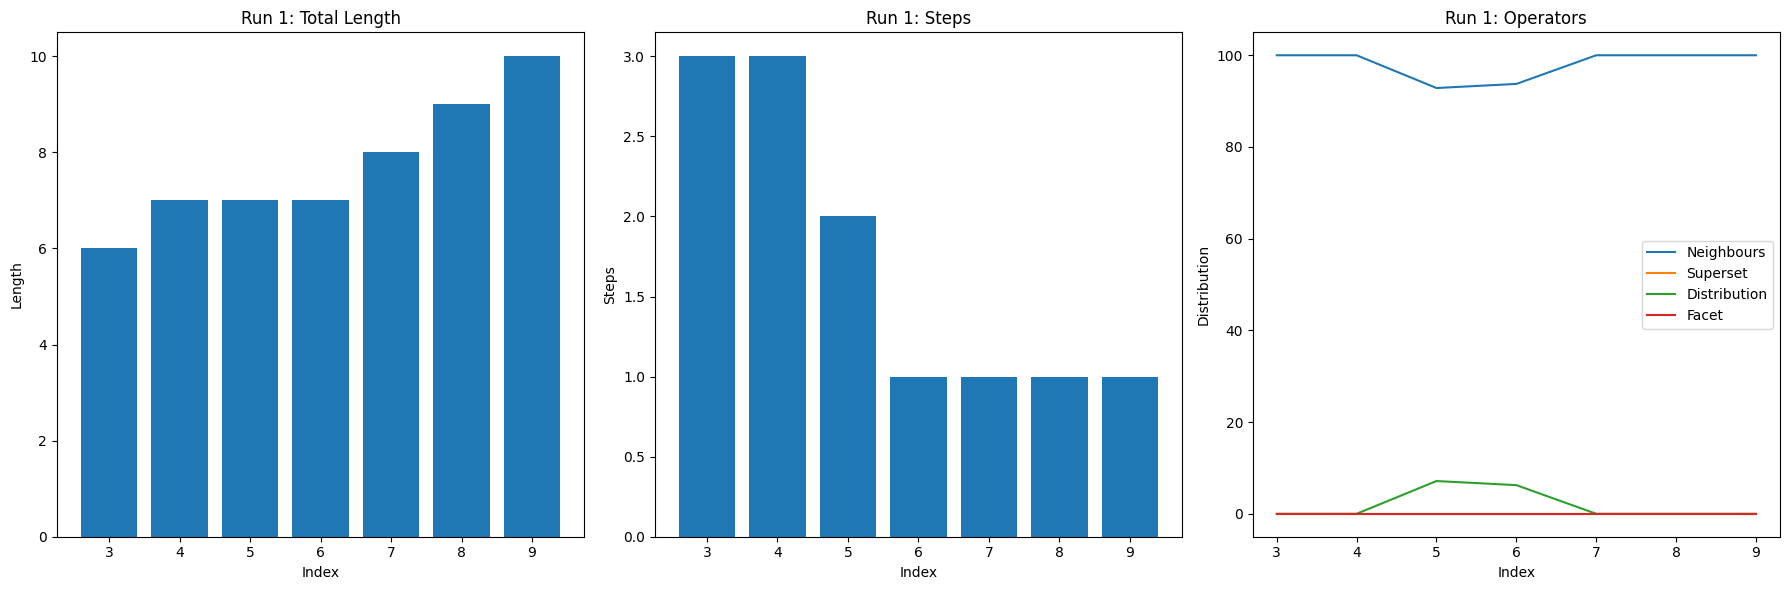

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 


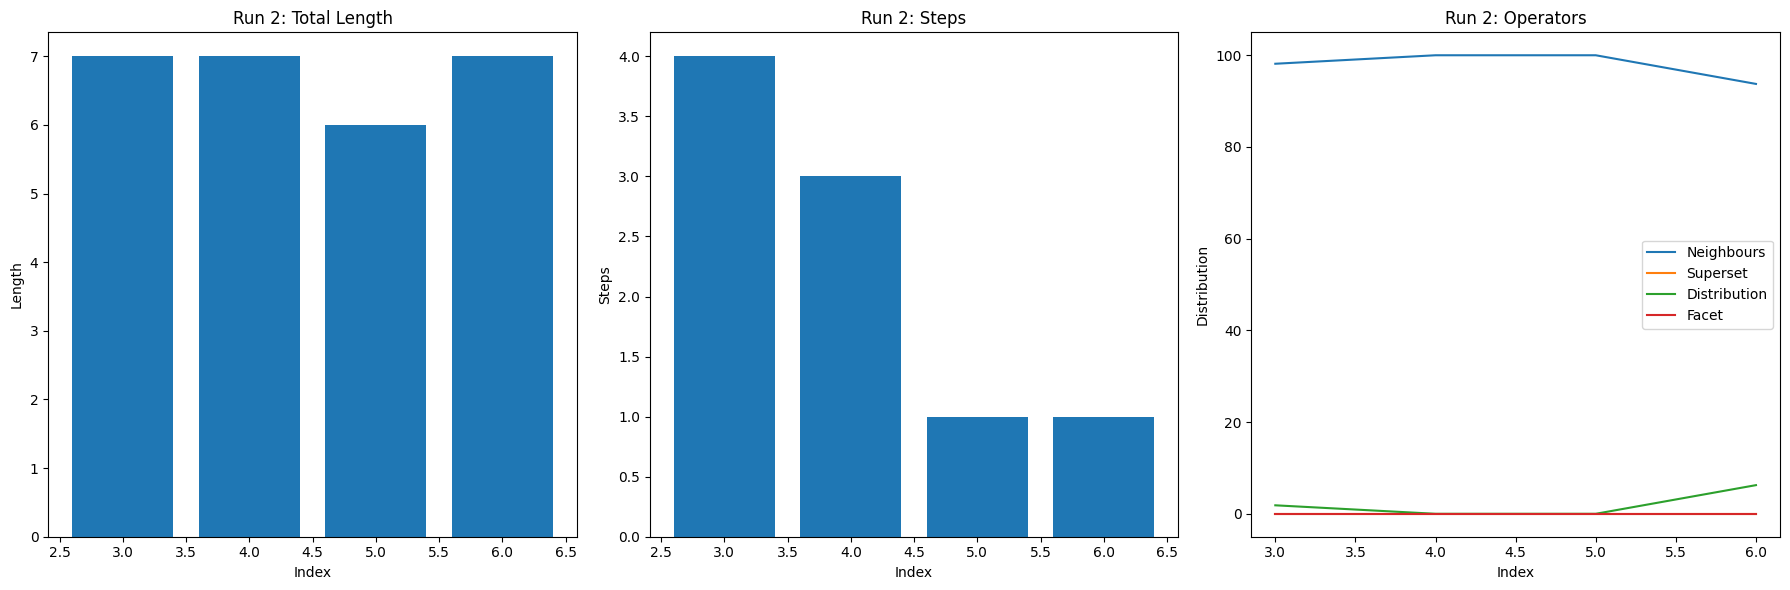

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 9, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: tota

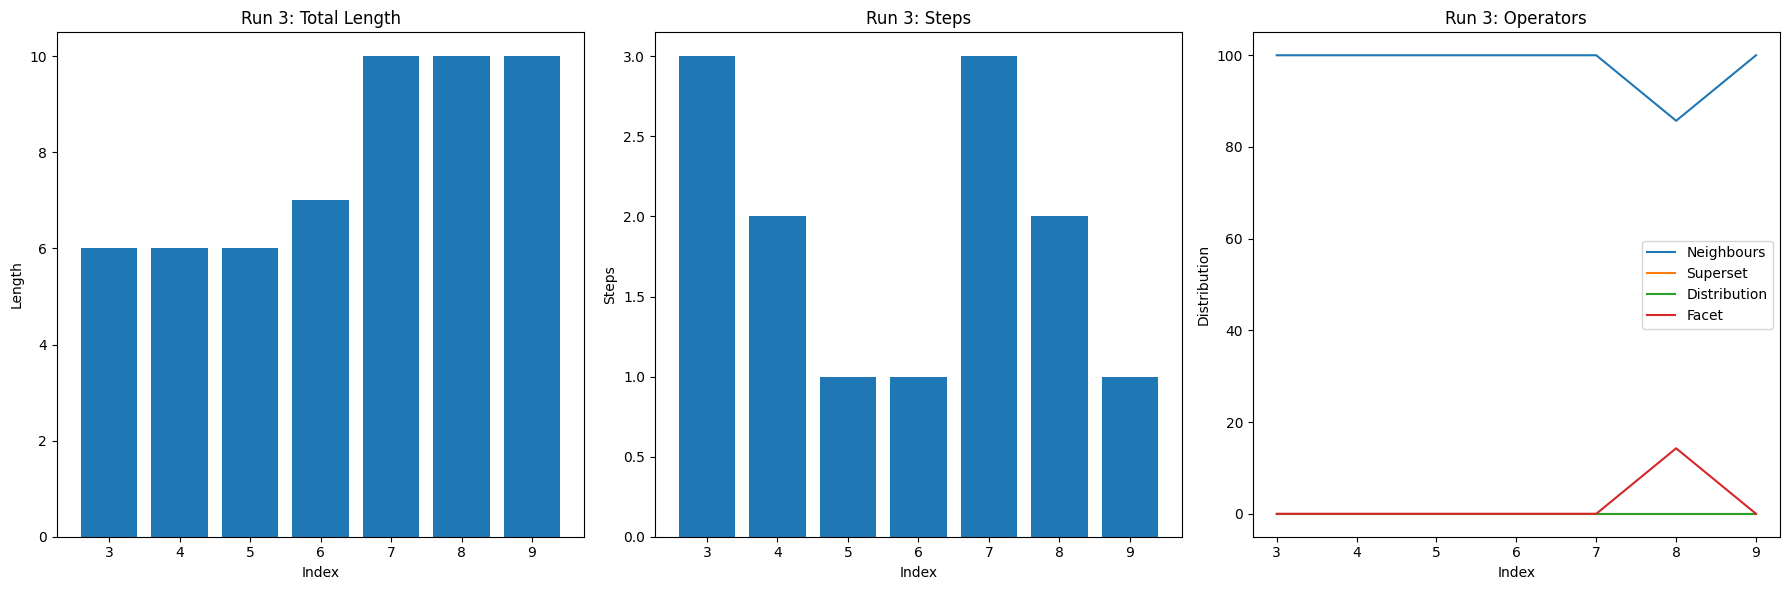

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 


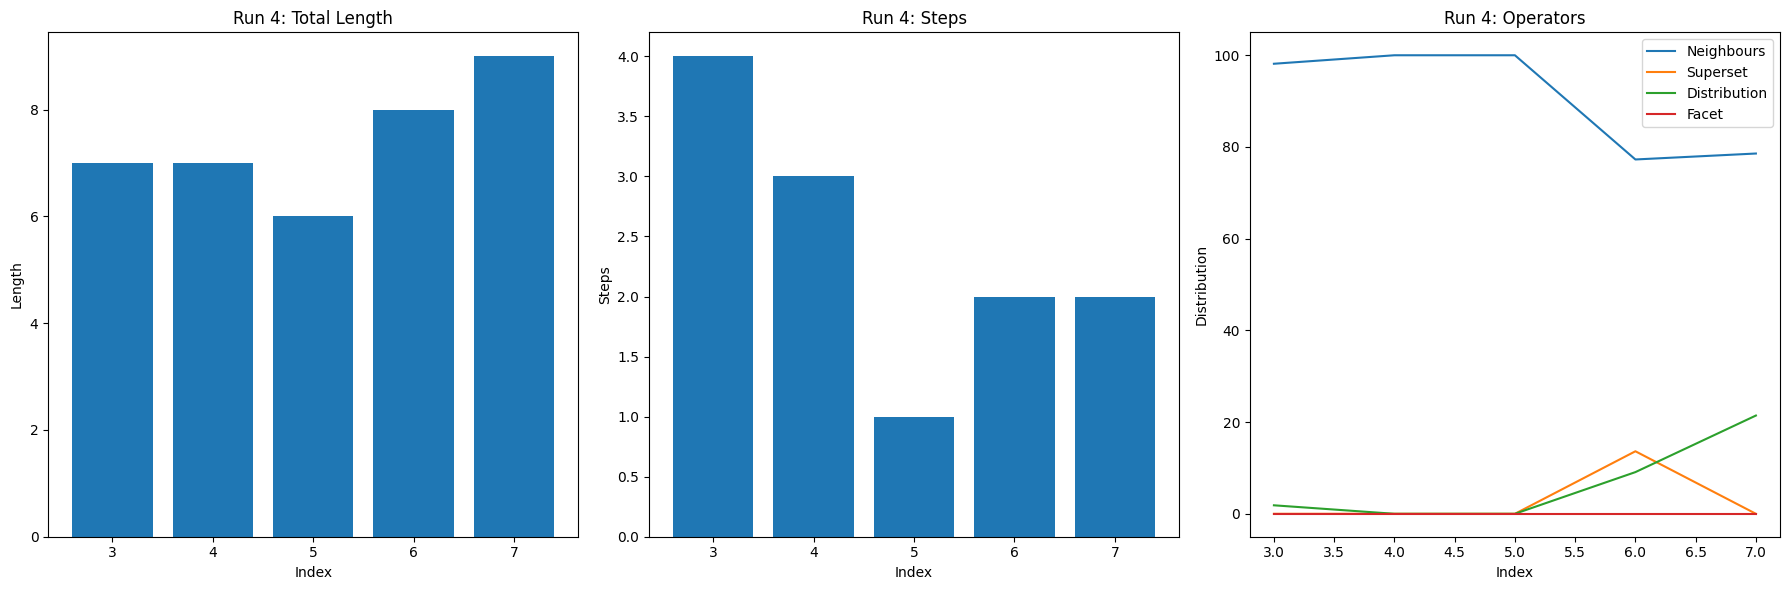

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 8, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 9, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: tota

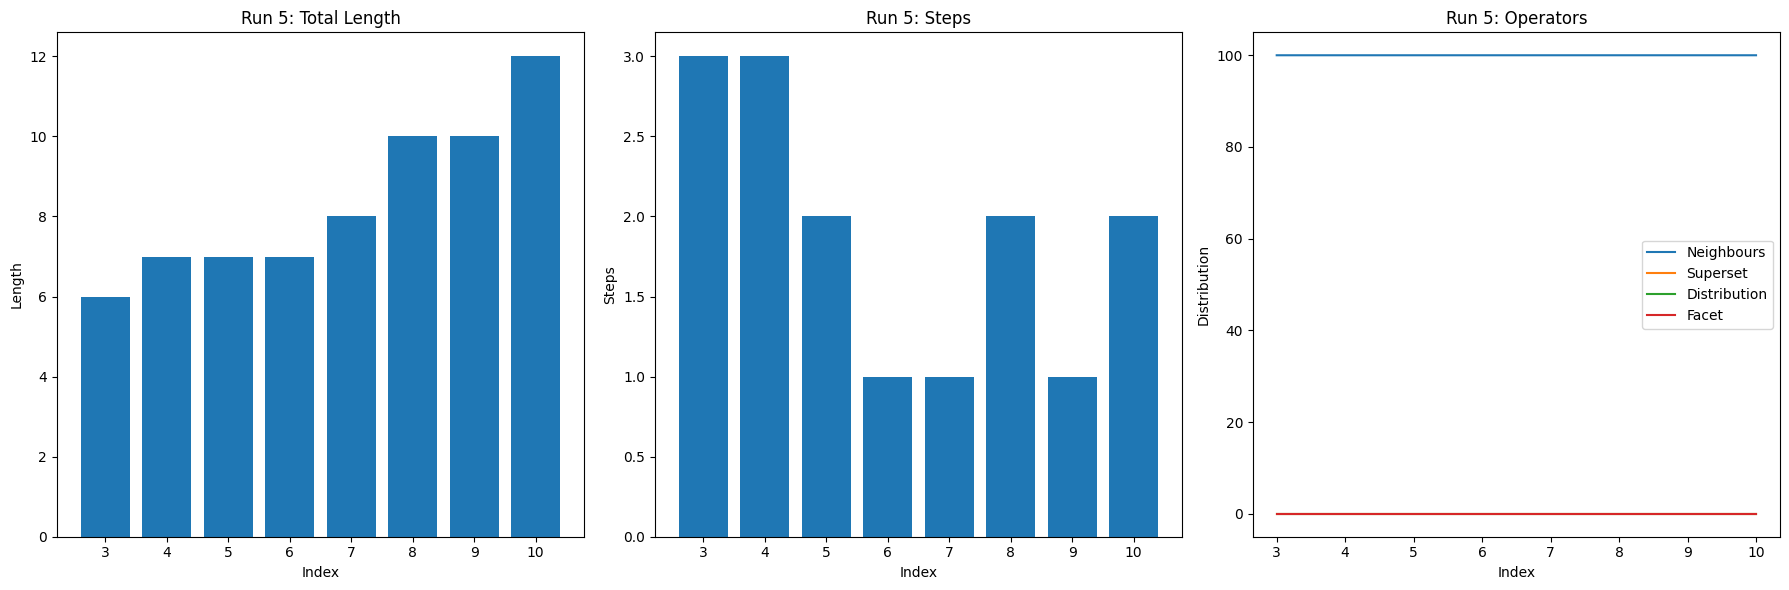

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 


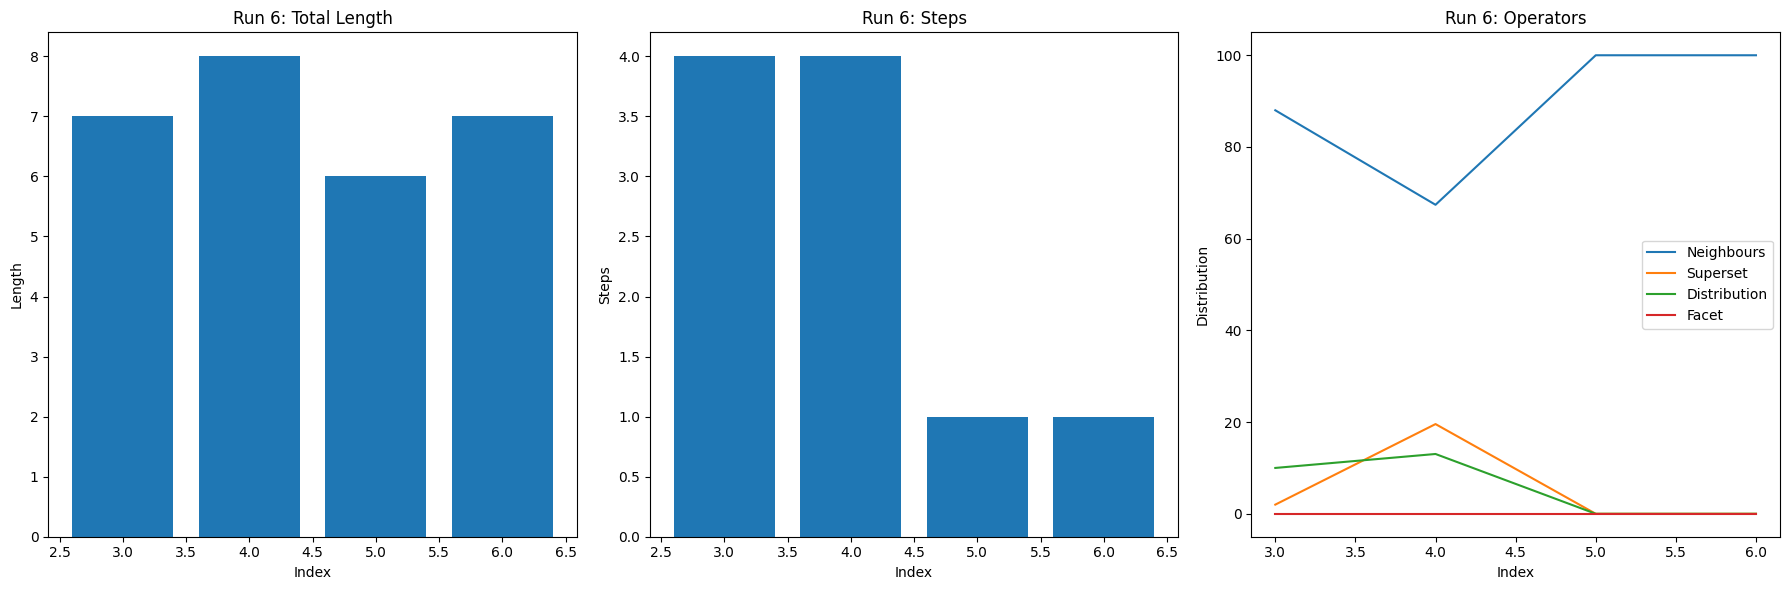

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 9, 
short pipeline: total_length = 7, 
short pipeline: tota

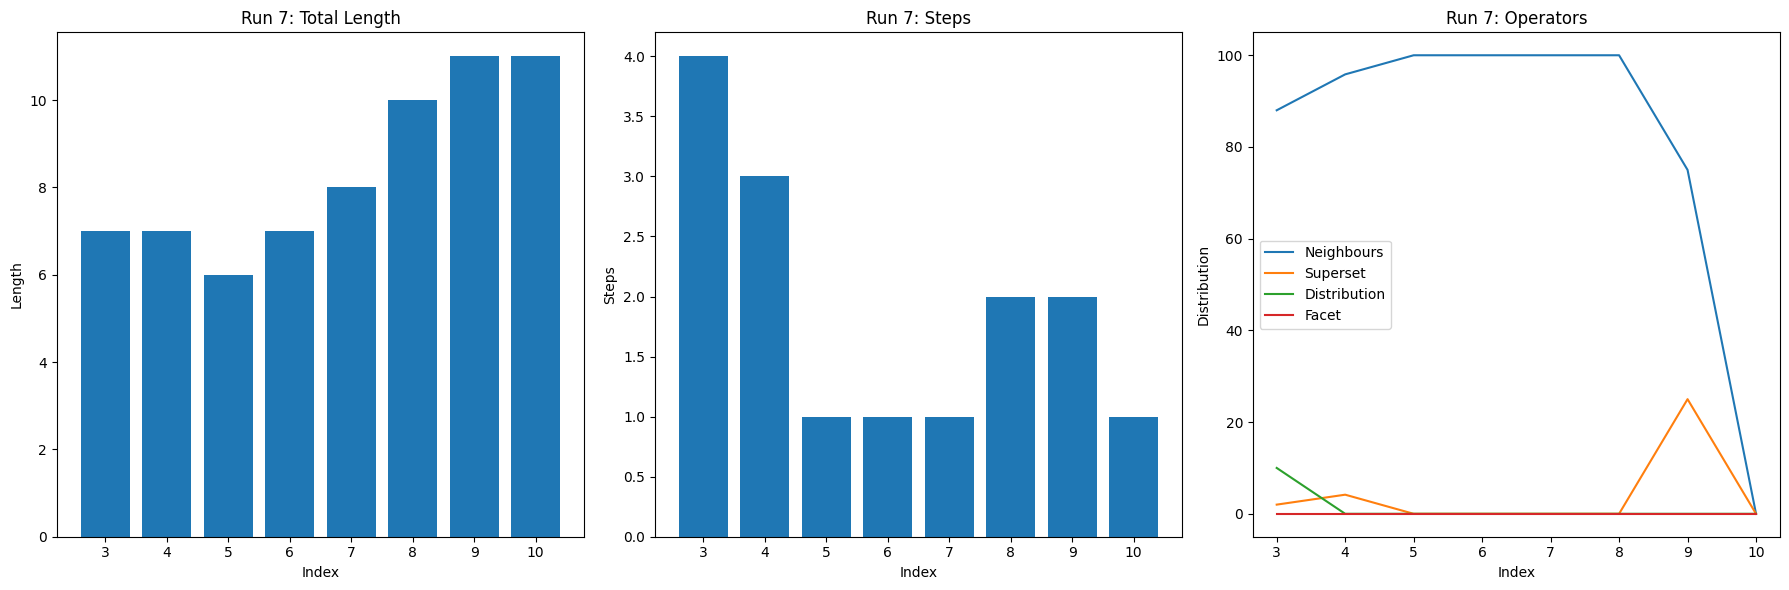

short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 9, 
short pipeline: tota

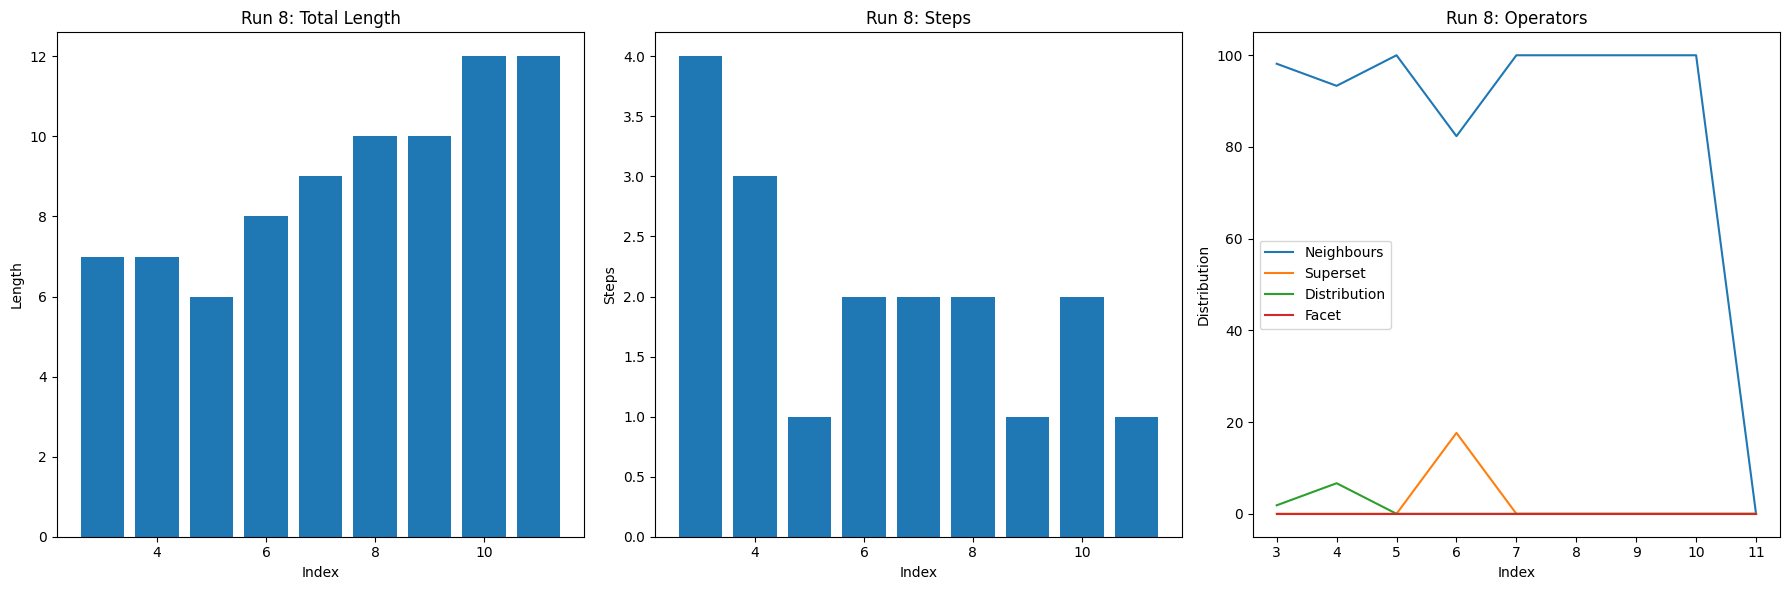

In [52]:
for run, raw_pipeline in enumerate(raw_pipelines):
    shorter_pipeline = raw_pipelines[3:]
    max_length = max(len(raw_pipeline), 1)  # Ensure there's at least one step
    total_length = np.zeros(max_length)
    steps = np.zeros(max_length)
    fam = np.zeros(max_length)
    neighbours = np.zeros(max_length)
    superset = np.zeros(max_length)
    distribution = np.zeros(max_length)
    facets = np.zeros(max_length)
    steps = np.zeros(max_length)
    fam = np.zeros(max_length)

    for i, node in enumerate(raw_pipeline):
        step = i + 3
        input_step = annotation(step, node)
        similar_steps = similarity_search(input=input_step, vector_store=vector_store_embeddings, step=step)
        
        if similar_steps:
            total_length[i] = length(similar_steps)
            steps[i] = length(similar_steps) - step
            fam[i] = familiarity(similar_steps)
            neighbours[i] = one_operator(similar_steps, 'remaining_operators_by_neighbors')
            superset[i] = one_operator(similar_steps,'remaining_operators_by_superset')
            distribution[i] = one_operator(similar_steps,'remaining_operators_by_distribution')
            facets[i] = one_operator(similar_steps,'remaining_operators_by_facet')
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot total_length
    axs[0].bar(range(3, len(total_length) + 3), total_length)
    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Length')
    axs[0].set_title(f'Run {run+1}: Total Length')

    # Plot steps
    axs[1].bar(range(3, len(steps) + 3), steps)
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Steps')
    axs[1].set_title(f'Run {run+1}: Steps')

    # # Plot familiarity
    # axs[2].bar(range(3, len(fam) + 3), fam)
    # axs[2].set_xlabel('Index')
    # axs[2].set_ylabel('Familiarity')
    # axs[2].set_title(f'Run {run+1}: Familiarity')
    
    axs[2].plot(range(3, len(neighbours) + 3), neighbours, label='Neighbours')
    axs[2].plot(range(3, len(superset) + 3), superset, label='Superset')
    axs[2].plot(range(3, len(distribution) + 3), distribution, label='Distribution')
    axs[2].plot(range(3, len(facets) + 3), facets, label='Facet')
    axs[2].set_xlabel('Index')
    axs[2].set_ylabel('Distribution')
    axs[2].set_title(f'Run {run+1}: Operators')
    axs[2].legend() 

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()


short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 7, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 6, 
short pipeline: total_length = 6, 
short pipeline: total_length = 8, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 7, 
short pipeline: total_length = 8, 
short pipeline: total_length = 8, 
short pipeline: tota

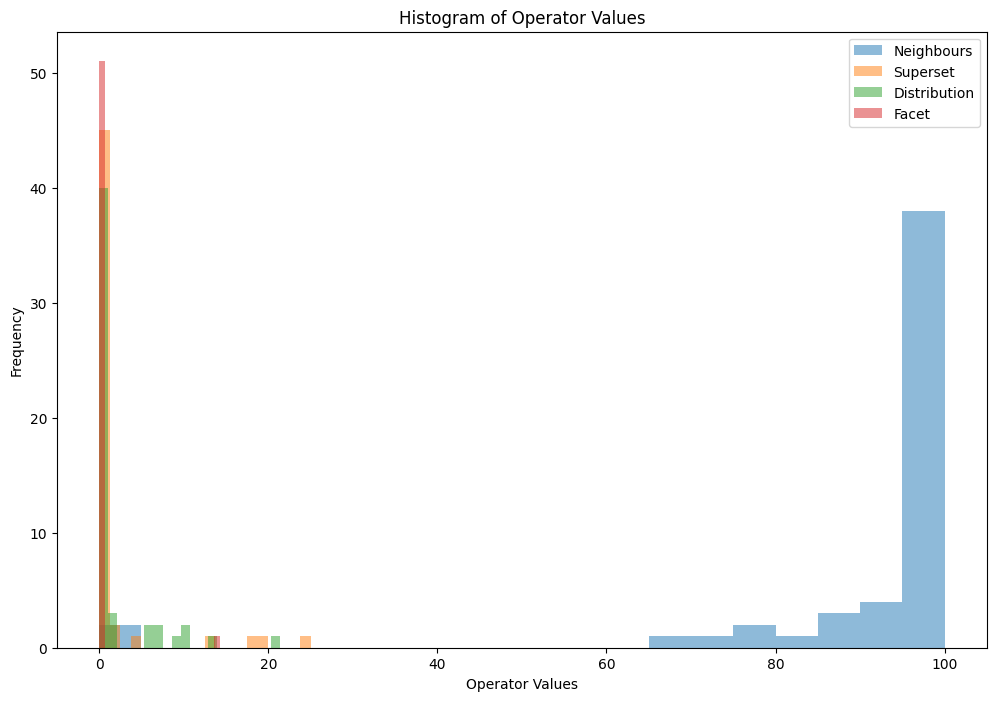

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Define empty lists to store data from all runs
all_neighbours = []
all_superset = []
all_distribution = []
all_facets = []

# Define the number of runs
for run, raw_pipeline in enumerate(raw_pipelines):
    # Calculate data for each run
    max_length = max(len(raw_pipeline), 1)  # Ensure there's at least one step
    neighbours = np.zeros(max_length)
    superset = np.zeros(max_length)
    distribution = np.zeros(max_length)
    facets = np.zeros(max_length)

    for i, node in enumerate(raw_pipeline):
        step = i + 3
        input_step = annotation(step, node)
        similar_steps = similarity_search(input=input_step, vector_store=vector_store_embeddings, step=step)
        
        if similar_steps:
            neighbours[i] = one_operator(similar_steps, 'remaining_operators_by_neighbors')
            superset[i] = one_operator(similar_steps,'remaining_operators_by_superset')
            distribution[i] = one_operator(similar_steps,'remaining_operators_by_distribution')
            facets[i] = one_operator(similar_steps,'remaining_operators_by_facet')
    
    # Append data from this run to the corresponding lists
    all_neighbours.extend(neighbours)
    all_superset.extend(superset)
    all_distribution.extend(distribution)
    all_facets.extend(facets)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

# Plot histograms for each type of operator
axs.hist(all_neighbours, bins=20, alpha=0.5, label='Neighbours')
axs.hist(all_superset, bins=20, alpha=0.5, label='Superset')
axs.hist(all_distribution, bins=20, alpha=0.5, label='Distribution')
axs.hist(all_facets, bins=20, alpha=0.5, label='Facet')

# Add labels and title
axs.set_xlabel('Operator Values')
axs.set_ylabel('Frequency')
axs.set_title('Histogram of Operator Values')

# Add legend
axs.legend()

# Show the plot
plt.show()


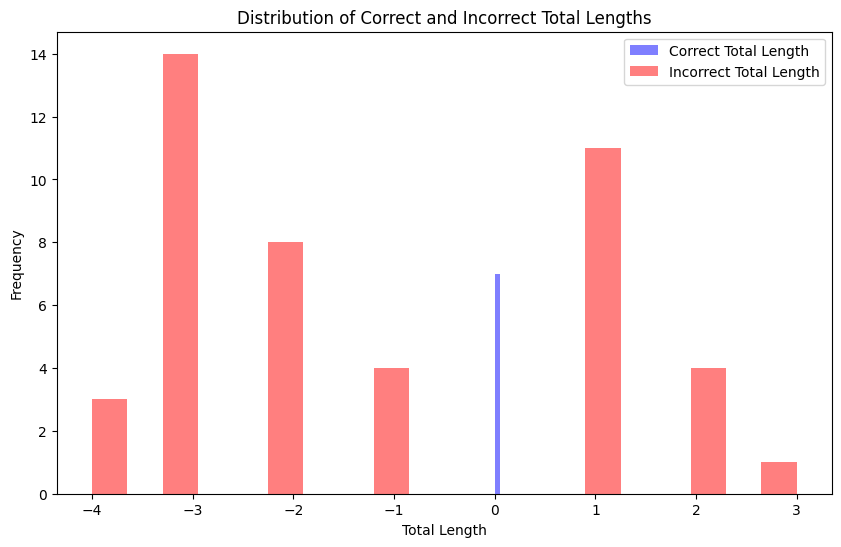

In [69]:
correct = []
incorrect = []
    
for run, raw_pipeline in enumerate(raw_pipelines):
    shorter_pipeline = raw_pipelines[3: ]
    max_length = max(len(raw_pipeline), 1) 
    total_length = np.zeros(max_length)


    for i, node in enumerate(raw_pipeline):
        step = i + 3
        input_step = annotation(step, node)
        similar_steps = similarity_search(input=input_step, vector_store=vector_store_embeddings, step=step)
        
        if similar_steps:
            total_length[i] = length(similar_steps)
            
    for elem in total_length:
        if elem == len(raw_pipeline):
            correct.append(0)
        else:
            incorrect.append(len(raw_pipeline) - elem)
        

fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for correct and incorrect total lengths
ax.hist(correct, bins=20, alpha=0.5, color='blue', label='Correct Total Length')
ax.hist(incorrect, bins=20, alpha=0.5, color='red', label='Incorrect Total Length')

# Add labels and title
ax.set_xlabel('Total Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Correct and Incorrect Total Lengths')
ax.legend()


plt.show()


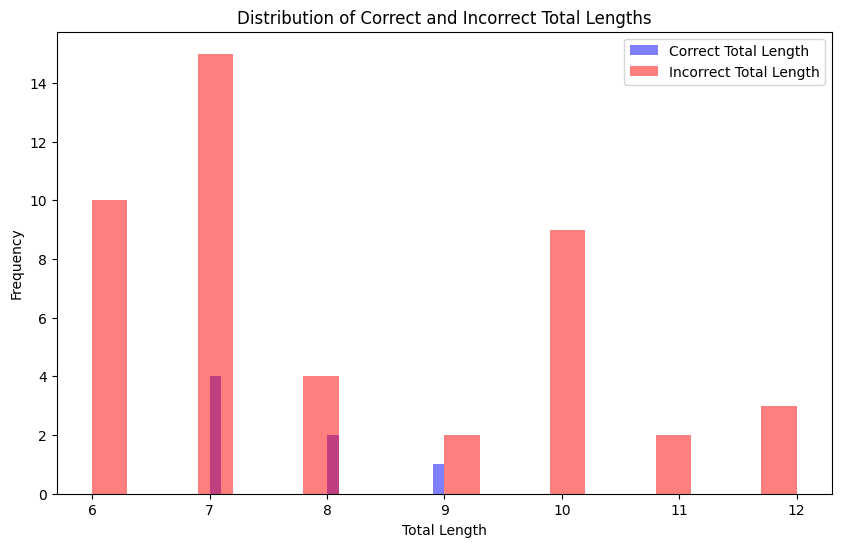

In [70]:
correct = []
incorrect = []
    
for run, raw_pipeline in enumerate(raw_pipelines):
    shorter_pipeline = raw_pipelines[3: ]
    max_length = max(len(raw_pipeline), 1) 
    total_length = np.zeros(max_length)


    for i, node in enumerate(raw_pipeline):
        step = i + 3
        input_step = annotation(step, node)
        similar_steps = similarity_search(input=input_step, vector_store=vector_store_embeddings, step=step)
        
        if similar_steps:
            total_length[i] = length(similar_steps)
            
    for elem in total_length:
        if elem == len(raw_pipeline):
            correct.append(elem)
        else:
            incorrect.append(elem)
        

fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for correct and incorrect total lengths
ax.hist(correct, bins=20, alpha=0.5, color='blue', label='Correct Total Length')
ax.hist(incorrect, bins=20, alpha=0.5, color='red', label='Incorrect Total Length')

# Add labels and title
ax.set_xlabel('Total Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Correct and Incorrect Total Lengths')
ax.legend()


plt.show()


In [65]:

for run, raw_pipeline in enumerate(raw_pipelines):

    shorter_pipeline = raw_pipeline[3:]
    
    print('\nRUN ', run, '\n')

    for i, node in enumerate(shorter_pipeline):
        step = i + 3
        input_step = annotation(step, node)
        similar_steps = similarity_search(input=input_step, vector_store=vector_store_embeddings, step=step)
        
        print('\n', 'step ', step, '\n')
        try:
            generate_guidance(similar_steps, step)
        except:
            print('no similar_steps')


RUN  0 


 step  3 

 On average 4 step/s, you will reach a scattered set with an expected final familiarity of 0.0. 
 You are more likely to get there by focusing on the by_neighbors and by_distribution operators and on g and z dimensions 
 You will probably finish with total length of 7. 
 You get this guidance because: in the 15 similar pipelines the following distribution of operator by_neighbors is 91.67, by_distribution is 8.33, by_superset is 0.0, by_facet is 0.0; 
 the distribution of dimension g is 29.09, z is 23.64, i is 21.82, redshift is 10.91. 

 step  4 

 On average 2 step/s, you will reach a concentrated set with an expected final familiarity of 0.0. 
 You are more likely to get there by focusing on the by_neighbors and by_superset operators and on g and i dimensions 
 You will probably finish with total length of 6. 
 You get this guidance because: in the 15 similar pipelines the following distribution of operator by_neighbors is 100.0, by_superset is 0.0, by_distribu